## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

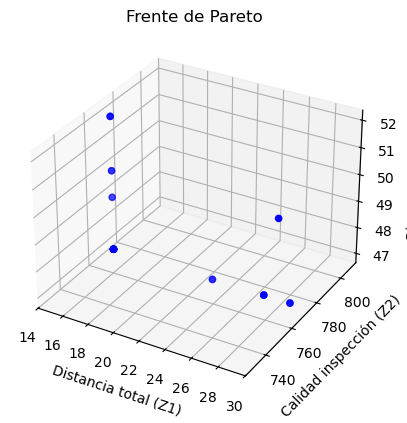

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *

def readcostmatrixcsv(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        data = list(reader)
    return np.array(data, dtype=int)

costmatrix = readcostmatrixcsv('/Users/angelicaortiz/MOS-Lab5/cost_matrix_10_nodes_1.5_spread.csv')
numnodos = len(costmatrix)
nodos = range(numnodos)
equipos = range(1)

calidadinspeccion = {
    1: 85, 2: 92, 3: 78, 4: 90, 5: 82,
    6: 88, 7: 95, 8: 75, 9: 84
}

riesgodatos = {
    (0, 1): 3, (0, 2): 2, (0, 3): 4, (0, 4): 5,
    (0, 5): 6, (0, 6): 3, (0, 7): 2, (0, 8): 4, (0, 9): 5,
    (2, 8): 9, (2, 9): 8, (3, 4): 5, (4, 9): 7,
    (5, 6): 7, (8, 9): 7
}
riesgoarcos = {(i, j): riesgodatos.get((i, j), 5) for i in nodos for j in nodos if i != j}

# calcular fmax fmin para normalizar
def calcularextremosobjetivos():
    extremos = {}

    def restriccionesbase(model):
        def visitonce(model, j):
            if j != 0:
                return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
            return Constraint.Skip
        model.visitonce = Constraint(model.N, rule=visitonce)

        def salidadeposito(model, k):
            return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
        model.salida = Constraint(model.K, rule=salidadeposito)

        def entradadeposito(model, k):
            return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
        model.entrada = Constraint(model.K, rule=entradadeposito)

        def flujo(model, i, k):
            if i != 0:
                return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
            return Constraint.Skip
        model.flujo = Constraint(model.N, model.K, rule=flujo)

        def mtzrule(model, i, j, k):
            if i != 0 and j != 0 and i != j:
                return model.u[i, k] - model.u[j, k] + numnodos * model.x[i, j, k] <= numnodos - 1
            return Constraint.Skip
        model.subtours = Constraint(model.N, model.N, model.K, rule=mtzrule)

    objetivos = {
        'z1': (lambda m: sum(m.x[i, j, k] * costmatrix[i][j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize),
        'z2': (lambda m: sum(calidadinspeccion.get(j, 0) *
                             sum(m.x[i, j, k] for i in m.N if i != j for k in m.K)
                             for j in m.N if j != 0), maximize),
        'z3': (lambda m: sum(m.x[i, j, k] * riesgoarcos[i, j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize)
    }

    for nombre, (expr, sentido) in objetivos.items():
        for ext in ['min', 'max']:
            model = ConcreteModel()
            model.N = Set(initialize=nodos)
            model.K = Set(initialize=equipos)
            model.x = Var(model.N, model.N, model.K, domain=Binary)
            model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, numnodos - 1))
            z = expr(model)
            model.Obj = Objective(expr=z, sense=minimize if ext == 'min' else maximize)
            restriccionesbase(model)
            SolverFactory('glpk').solve(model)
            extremos[f"{nombre}{ext}"] = value(z)

    return extremos

extremos = calcularextremosobjetivos()
z1min, z1max = extremos['z1min'], extremos['z1max']
z2min, z2max = extremos['z2min'], extremos['z2max']
z3min, z3max = extremos['z3min'], extremos['z3max']

z1vec, z2vec, z3vec = [], [], []

valoresW = np.linspace(0, 1, 8)
pesocombinaciones = [(w1, w2, 1 - w1 - w2) for w1 in valoresW  for w2 in valoresW  if w1 + w2 <= 1]

for w1, w2, w3 in pesocombinaciones:
    model = ConcreteModel()
    model.N = Set(initialize=nodos)
    model.K = Set(initialize=equipos)
    model.x = Var(model.N, model.N, model.K, domain=Binary)
    model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, numnodos - 1))

    z1 = sum(model.x[i, j, k] * costmatrix[i][j]
             for i in model.N for j in model.N if i != j for k in model.K)

    z2real = sum(calidadinspeccion.get(j, 0) *
                  sum(model.x[i, j, k] for i in model.N if i != j for k in model.K)
                  for j in model.N if j != 0)

    z3 = sum(model.x[i, j, k] * riesgoarcos[i, j]
             for i in model.N for j in model.N if i != j for k in model.K)

    # normalización 
    z1norm = (z1 - z1min) / (z1max - z1min) if z1max != z1min else 0
    z2norm = (z2max - z2real) / (z2max - z2min) if z2max != z2min else 0 
    z3norm = (z3 - z3min) / (z3max - z3min) if z3max != z3min else 0

    model.Obj = Objective(expr=w1 * z1norm + w2 * z2norm + w3 * z3norm, sense=minimize)

    def visitonce(model, j):
        if j != 0:
            return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
        return Constraint.Skip
    model.visitonce = Constraint(model.N, rule=visitonce)

    def salidadeposito(model, k):
        return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
    model.salida = Constraint(model.K, rule=salidadeposito)

    def entradadeposito(model, k):
        return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
    model.entrada = Constraint(model.K, rule=entradadeposito)

    def flujo(model, i, k):
        if i != 0:
            return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
        return Constraint.Skip
    model.flujo = Constraint(model.N, model.K, rule=flujo)

    def mtzrule(model, i, j, k):
        if i != 0 and j != 0 and i != j:
            return model.u[i, k] - model.u[j, k] + numnodos * model.x[i, j, k] <= numnodos - 1
        return Constraint.Skip
    model.subtours = Constraint(model.N, model.N, model.K, rule=mtzrule)

    SolverFactory('glpk').solve(model)

    z1vec.append(value(z1))
    z2vec.append(value(z2real))
    z3vec.append(value(z3))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z1vec, z2vec, z3vec, c='blue', marker='o')
ax.set_xlabel('Distancia total')
ax.set_ylabel('Calidad inspección')
ax.set_zlabel('Riesgo total')
plt.title('Frente de Pareto')
plt.grid(True)
plt.show()
